In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tempfile

In [2]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data\\data with rsi.csv")
print(df)

      Unnamed: 0.1  Unnamed: 0              date     open     high      low  \
0                0           0    4/22/2025 3:00  3471.10  3475.10  3466.80   
1                1           1    4/22/2025 4:00  3472.57  3494.08  3472.28   
2                2           2    4/22/2025 5:00  3487.55  3487.94  3479.20   
3                3           3    4/22/2025 6:00  3484.95  3495.01  3474.14   
4                4           4    4/22/2025 7:00  3492.59  3499.45  3477.36   
...            ...         ...               ...      ...      ...      ...   
2937          2937        2937  10/10/2025 11:00  3995.56  3999.84  3990.61   
2938          2938        2938  10/10/2025 12:00  3993.50  3999.70  3983.56   
2939          2939        2939  10/10/2025 13:00  3987.35  3993.31  3980.01   
2940          2940        2940  10/10/2025 14:00  3985.33  3997.99  3975.26   
2941          2941        2941  10/10/2025 15:00  3978.64  3993.93  3970.39   

        close  volume  past_ret_1h  past_ret_2h  pa

In [3]:
# Keep only UP (1) and DOWN (2)
df_binary = df[df['forward regime'].isin(['upward','downward'])].copy()

# Map labels to 0/1 for binary classification
df_binary['label'] = df_binary['forward regime'].map({'downward':0, 'upward':1})


In [4]:
features = ["open", "1 percent prediction", "past_ret_16h", "RSI_16"]

X = df_binary[features]
y = df_binary["label"]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [6]:
# Original class counts
class_counts = y_train.value_counts()

# Identify the classes we want to apply weighting to
classes_to_weight = [0, 1]   # upward, downward

class_weights = {}

for c in classes_to_weight:
    class_weights[c] = len(y_train) / class_counts[c]

# Set RANGE weight = 1 (neutral)
class_weights[2] = 1.0

print("Final class weights:", class_weights)


Final class weights: {0: 2.2411575562700965, 1: 1.805699481865285, 2: 1.0}


In [7]:
# second method

class_counts = y_train.value_counts()
class_weights = {
    0: len(y_train)/class_counts[0],  # downward
    1: len(y_train)/class_counts[1]   # upward
}
print(class_weights)

{0: 2.2411575562700965, 1: 1.805699481865285}


In [9]:
import os
os.getcwd()

'c:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data'

In [10]:
os.chdir("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data")

In [11]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function="Logloss",
    depth=6,
    learning_rate=0.03,
    iterations=2000,             # large, but early stopping will stop when needed
    random_seed=42,
    class_weights=class_weights, # important for imbalance
    eval_metric="TotalF1",       # better than accuracy for imbalanced 3-class problems
    od_type="Iter",
    od_wait=100,                 # stop early if no improvement
    task_type="GPU",             # auto falls back to CPU if no GPU
    verbose=200
)

model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)


0:	learn: 0.6503502	test: 0.6349456	best: 0.6349456 (0)	total: 129ms	remaining: 4m 18s
200:	learn: 0.7980145	test: 0.6901932	best: 0.6906007 (153)	total: 6.28s	remaining: 56.2s
bestTest = 0.6999527683
bestIteration = 208
Shrink model to first 209 iterations.


In [12]:
y_pred = model.predict(X_valid)
y_pred = y_pred.astype(int).flatten()

print("\nCLASSIFICATION REPORT")
print(classification_report(y_valid, y_pred))

print("\nCONFUSION MATRIX")
print(confusion_matrix(y_valid, y_pred))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       134
           1       0.73      0.72      0.73       165

    accuracy                           0.70       299
   macro avg       0.70      0.70      0.70       299
weighted avg       0.70      0.70      0.70       299


CONFUSION MATRIX
[[ 91  43]
 [ 46 119]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

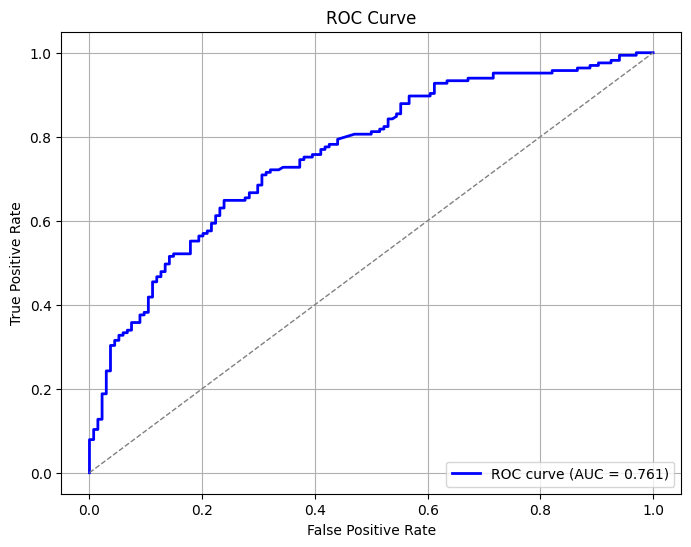

In [14]:
y_proba = model.predict_proba(X_valid)[:,1]


fpr, tpr, _ = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

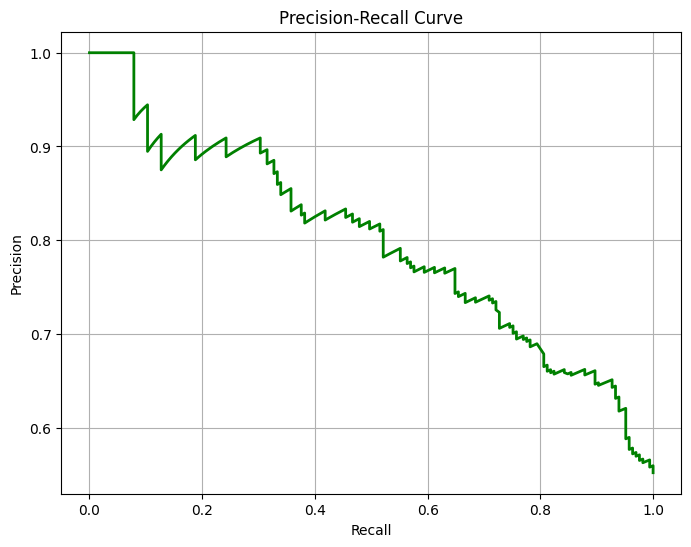

In [15]:

precision, recall, _ = precision_recall_curve(y_valid, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

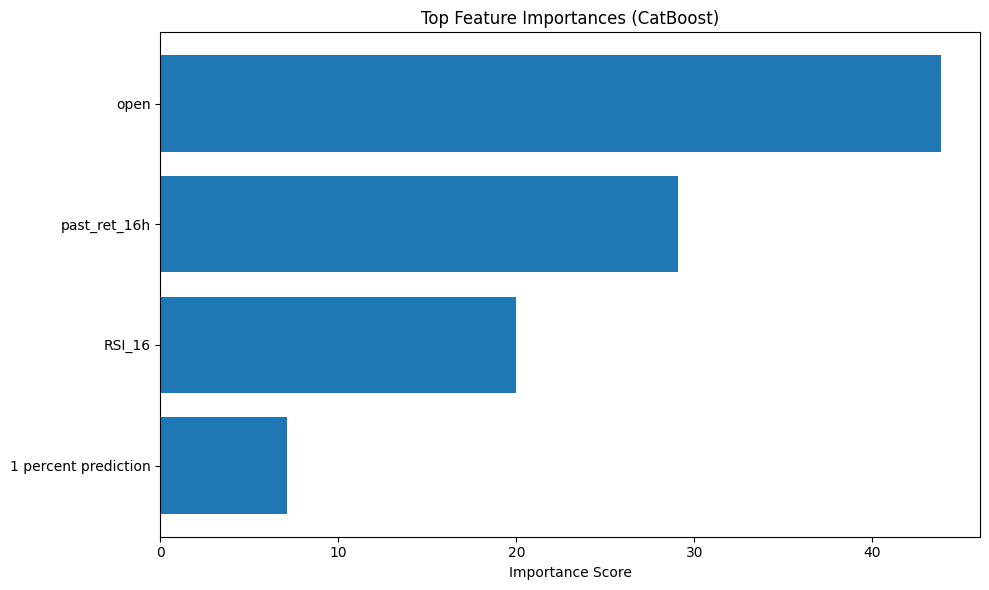

In [16]:
feature_importance = np.array(model.get_feature_importance())
feature_names = np.array(X_train.columns)

# Sort descending
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_names = feature_names[sorted_idx]
sorted_scores = feature_importance[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(sorted_names[:15], sorted_scores[:15])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top Feature Importances (CatBoost)")
plt.tight_layout()
plt.show()